In [2]:
#install.packages("doParallel")

In [3]:
library(data.table)
library(parallel)
library(digest)

In [4]:
read_bin_packing_instance <- function(filename) {
  lines <- readLines(filename)
  P <- as.integer(lines[1])  # Número de instancias de problemas
  problems <- list()
  index <- 2
  for (i in 1:P) {
    problem_id <- trimws(lines[index])
    index <- index + 1
    bin_info <- strsplit(trimws(lines[index]), "\\s+")[[1]]
    bin_capacity <- as.numeric(bin_info[1])
    num_items <- as.integer(bin_info[2])
    best_known_solution <- as.integer(bin_info[3])
    index <- index + 1
    items <- numeric(num_items)
    for (j in 1:num_items) {
      items[j] <- as.numeric(trimws(lines[index]))
      index <- index + 1
    }
    problems[[i]] <- list(
      problem_id = problem_id,
      bin_capacity = bin_capacity,
      num_items = num_items,
      best_known_solution = best_known_solution,
      items = items
    )
  }
  return(problems)
}

In [5]:
# Función para transformar la solución en una lista de contenedores
transform_solution <- function(solution, item_sizes, bin_capacity) {
  bins <- list()
  current_bin <- numeric()
  current_bin_capacity <- 0
  
  for (i in solution) {
    item_size <- item_sizes[i]
    if (current_bin_capacity + item_size <= bin_capacity) {
      current_bin <- c(current_bin, item_size)
      current_bin_capacity <- current_bin_capacity + item_size
    } else {
      bins <- c(bins, list(current_bin))
      current_bin <- item_size
      current_bin_capacity <- item_size
    }
  }
  bins <- c(bins, list(current_bin))
  return(bins)
}

In [6]:
shaking <- function(solution, k) {
  n <- length(solution)
  perturbation_type <- sample(1:3, 1)
  
  if (perturbation_type == 1) {
    # Realizar k intercambios aleatorios
    for (i in 1:k) {
      idx1 <- sample(1:n, 1)
      idx2 <- sample(1:n, 1)
      temp <- solution[idx1]
      solution[idx1] <- solution[idx2]
      solution[idx2] <- temp
    }
  } else if (perturbation_type == 2) {
    # Perturbación basada en segmentos
    segment_length <- sample(2:floor(n / 2), 1)
    start_idx <- sample(1:(n - segment_length + 1), 1)
    segment <- solution[start_idx:(start_idx + segment_length - 1)]
    shuffled_segment <- sample(segment)
    solution[start_idx:(start_idx + segment_length - 1)] <- shuffled_segment
  } else if (perturbation_type == 3) {
    # Rotar un segmento de k elementos
    segment_length <- sample(2:floor(n / 2), 1)
    start_idx <- sample(1:(n - segment_length + 1), 1)
    segment <- solution[start_idx:(start_idx + segment_length - 1)]
    rotated_segment <- c(segment[-1], segment[1])
    solution[start_idx:(start_idx + segment_length - 1)] <- rotated_segment
  }
  
  return(solution)
}


In [7]:
best_fit_decreasing <- function(elements, container_capacity) {
  original_indices <- seq_along(elements)
  sorted_indices <- order(elements, decreasing = TRUE)
  elements_sorted <- elements[sorted_indices]
  
  containers <- list()
  assignments <- integer(length(elements)) # Para almacenar las asignaciones de contenedores
  
  for (i in seq_along(elements_sorted)) {
    element <- elements_sorted[i]
    best_fit_index <- -1
    min_space_left <- container_capacity + 1
    
    for (j in seq_along(containers)) {
      space_left <- container_capacity - sum(unlist(containers[[j]]))
      if (space_left >= element && space_left < min_space_left) {
        min_space_left <- space_left
        best_fit_index <- j
      }
    }
    
    if (best_fit_index == -1) {
      containers <- append(containers, list(c(element)))
      best_fit_index <- length(containers)
    } else {
      containers[[best_fit_index]] <- c(containers[[best_fit_index]], element)
    }
    
    assignments[sorted_indices[i]] <- best_fit_index
  }
  
  return(assignments)
}


In [8]:
BinPacking <- setRefClass(
  "BinPacking",
  fields = list(
    item_sizes_dt = "data.table",
    bin_capacity = "numeric",
    eval_cache = "list"
  ),
  methods = list(
    evaluate = function(permutation) {
      perm_key <- digest(permutation, algo = "md5")  # Usar digest para una clave de caché eficiente
      if (!is.null(eval_cache[[perm_key]])) {
        return(eval_cache[[perm_key]])
      }
      
      dt <- item_sizes_dt[permutation, ]
      item_sizes <- dt$size
      
      bin_capacities <- numeric(length(item_sizes))  # Preasignar un vector de tamaño máximo posible
      current_bin_capacity <- 0
      bin_count <- 1  # Iniciar el conteo de bins con 1
      
      for (item_size in item_sizes) {
        if (current_bin_capacity + item_size <= bin_capacity) {
          current_bin_capacity <- current_bin_capacity + item_size
        } else {
          bin_capacities[bin_count] <- current_bin_capacity
          current_bin_capacity <- item_size
          bin_count <- bin_count + 1
        }
      }
      
      bin_capacities[bin_count] <- current_bin_capacity
      
      eval_cache[[perm_key]] <<- bin_count  # Guardar el número de bins en la caché
      
      return(bin_count)
    },
    initialize = function(item_sizes, bin_capacity) {
      .self$item_sizes_dt <- data.table(index = 1:length(item_sizes), size = item_sizes)
      .self$bin_capacity <- bin_capacity
      .self$eval_cache <- list()
    }
  )
)


In [9]:
local_search <- function(bins, bin_capacity, binpacking_instance) {
  current_solution <- bins
  best_solution <- current_solution
  best_cost <- binpacking_instance$evaluate(current_solution)
  improved <- TRUE
  
  while (improved) {
    improved <- FALSE
    for (i in 1:(length(current_solution) - 1)) {
      for (j in (i + 1):length(current_solution)) {
        new_solution <- current_solution
        new_solution[c(i, j)] <- new_solution[c(j, i)]
        new_cost <- binpacking_instance$evaluate(new_solution)
        if (new_cost < best_cost) {
          best_solution <- new_solution
          best_cost <- new_cost
          improved <- TRUE
        }
      }
    }
    if (improved) {
      current_solution <- best_solution
    }
  }
  
  return(best_solution)
}

In [10]:
library(doParallel)
registerDoParallel(cores = detectCores())

local_search <- function(bins, bin_capacity, binpacking_instance, max_iter = 20, max_exchanges = 100, tabu_list = list(), tabu_size = 20) {
  current_solution <- bins
  best_solution <- current_solution
  best_cost <- binpacking_instance$evaluate(current_solution)
  improved <- TRUE
  iteration <- 0

  while (improved && iteration < max_iter) {
    improved <- FALSE
    iteration <- iteration + 1
    
    # Generar todas las combinaciones posibles de pares de índices para intercambios
    exchanges <- expand.grid(1:(length(current_solution) - 1), 2:length(current_solution))
    exchanges <- exchanges[sample(nrow(exchanges), min(nrow(exchanges), max_exchanges)), ]
    
    # Evaluar intercambios en paralelo
    results <- foreach(k = 1:nrow(exchanges), .combine = rbind, .packages = 'data.table') %dopar% {
      i <- exchanges[k, 1]
      j <- exchanges[k, 2]
      
      new_solution <- current_solution
      new_solution[c(i, j)] <- new_solution[c(j, i)]
      
      new_cost <- binpacking_instance$evaluate(new_solution)
      list(new_solution = new_solution, new_cost = new_cost, i = i, j = j)
    }
    
    # Evaluar movimientos de reubicación (mover un elemento a otra posición)
    results <- rbind(results, foreach(k = 1:nrow(exchanges), .combine = rbind, .packages = 'data.table') %dopar% {
      i <- exchanges[k, 1]
      j <- exchanges[k, 2]
      
      if (i != j) {
        new_solution <- current_solution
        temp <- new_solution[i]
        new_solution <- new_solution[-i]
        new_solution <- append(new_solution, temp, j-1)
        
        new_cost <- binpacking_instance$evaluate(new_solution)
        list(new_solution = new_solution, new_cost = new_cost, i = i, j = j)
      } else {
        list(new_solution = current_solution, new_cost = best_cost, i = i, j = j)
      }
    })
    
    best_result <- NULL
    for (result in results) {
      if (is.list(result) && !is.null(result$new_cost) && result$new_cost < best_cost && !any(sapply(tabu_list, function(x) all(x == result$new_solution)))) {
        best_result <- result
        best_cost <- result$new_cost
        improved <- TRUE
      }
    }
    
    if (!is.null(best_result)) {
      best_solution <- best_result$new_solution
      tabu_list <- c(tabu_list, list(best_solution))
      if (length(tabu_list) > tabu_size) tabu_list <- tabu_list[-1]
    }
    
    if (improved) {
      current_solution <- best_solution
    }
  }
  
  return(best_solution)
}


Cargando paquete requerido: foreach

Cargando paquete requerido: iterators



In [11]:
vns <- function(binpacking_instance, max_iter = 100, max_no_improve = 10) {
  initial_solution <- best_fit_decreasing(binpacking_instance$item_sizes_dt$size, binpacking_instance$bin_capacity)
  cat("initial solution", initial_solution, "\n")
  best_solution <- initial_solution
  best_cost <- binpacking_instance$evaluate(initial_solution)
  no_improve <- 0
  
  cost_per_iteration <- numeric()  # Cambiar a una lista dinámica
  
  for (iter in 1:max_iter) {    
    k <- 1
    while (k <= max_no_improve) {
      new_solution <- shaking(best_solution, k)
      new_solution <- local_search(new_solution, binpacking_instance$bin_capacity, binpacking_instance)
      new_cost <- binpacking_instance$evaluate(new_solution)
      
      cost_per_iteration <- c(cost_per_iteration, new_cost)  # Guardar new_cost
      
      if (new_cost < best_cost) {
        best_solution <- new_solution
        best_cost <- new_cost
        no_improve <- 0
        k <- 1
      } else {
        k <- k + 1
        no_improve <- no_improve + 1
      } 
      if (no_improve >= max_no_improve) break
    }
  }
  
  return(list(solution = best_solution, cost_per_iteration = cost_per_iteration))
}


In [18]:
library(dplyr)

analyze_results <- function(results) {
  num_bins <- sapply(results, function(x) x$num_bins)
  execution_times <- sapply(results, function(x) x$execution_time)
  
  summary_stats <- list(
    num_bins = list(
      mean = mean(num_bins),
      sd = sd(num_bins),
      min = min(num_bins),
      max = max(num_bins)
    ),
    execution_time = list(
      mean = mean(execution_times),
      sd = sd(execution_times),
      min = min(execution_times),
      max = max(execution_times)
    )
  )
  
  return(summary_stats)
}

In [12]:
file_path <- "./instances/binpack1.txt"
instances <- read_bin_packing_instance(file_path)
instance <- instances[[1]]
instance

Warning message in readLines(filename):
"incomplete final line found on './instances/binpack1.txt'"


$problem_id
[1] "u120_00"

$bin_capacity
[1] 150

$num_items
[1] 120

$best_known_solution
[1] 48

$items
  [1] 42 69 67 57 93 90 38 36 45 42 33 79 27 57 44 84 86 92 46 38 85 33 82 73 49
 [26] 70 59 23 57 72 74 69 33 42 28 46 30 64 29 74 41 49 55 98 80 32 25 38 82 30
 [51] 35 39 57 84 62 50 55 27 30 36 20 78 47 26 45 41 58 98 91 96 73 84 37 93 91
 [76] 43 73 85 81 79 71 80 76 83 41 78 70 23 42 87 43 84 60 55 49 78 73 62 36 44
[101] 94 69 32 96 70 84 58 78 25 80 58 66 83 24 98 60 42 43 43 39

initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 
Execution Time: 98.675 495.286 679.341 642.971 940.856 
  [1] 41 26 22  3 36  1 14  7  6 34 15 27 45 32 30 37 48 44 48 34 25 43 24  2 24
 [26] 47 42 31 39  9  7 10 14 39 49 17 47  8 45 48 47 45 19 25 27 37 42 12 48 45
 [51] 46 44 20 18 13  1 21 35 48 46 40 32  5 43 12 43  9 10  4 38 19 46  8 11 40
 [76] 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 35 23  4 34 39 15 46 40  6
[101] 33 47  5 29 21 11 35 29 18 17 23 42 49  3 16 43  2 41 41 44
[1] "Number of bins: 49"


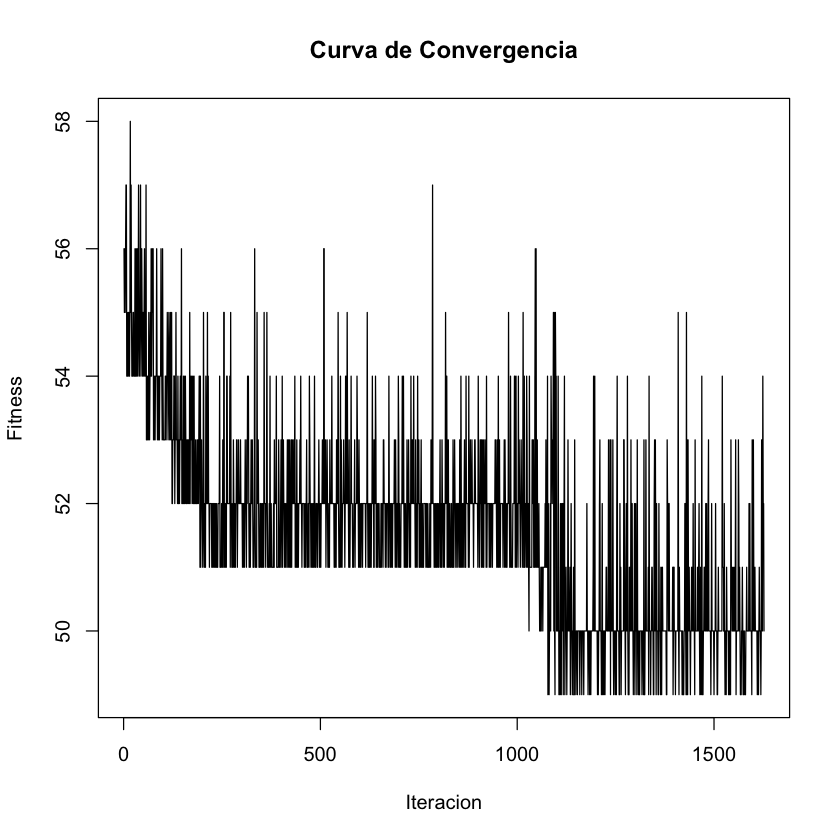

In [62]:
binpacking_instance <- BinPacking$new(item_sizes = instance$items, bin_capacity = instance$bin_capacity)

execution_time <- system.time({
  result <- vns(binpacking_instance, 1500, 20)
}) 

best_solution <- result$solution
cost_per_iteration <- result$cost_per_iteration

# Mostrar resultados
cat("Execution Time:", execution_time, "\n")
print(best_solution)  
print(paste("Number of bins:", binpacking_instance$evaluate(best_solution)))

par(bg = "white") 
# Graficar la curva de convergencia
plot(cost_per_iteration, type = 'l', main = "Curva de Convergencia", xlab = "Iteracion", ylab = "Fitness", col = "black")
beepr::beep() 


In [45]:
run_vns_multiple_times <- function(instance, num_runs = 11, max_iter = 1500, max_no_improve = 20) {
  binpacking_instance <- BinPacking$new(item_sizes = instance$items, bin_capacity = instance$bin_capacity)
  
  results <- list()
  
  for (run in 1:num_runs) {
    execution_time <- system.time({
      result <- vns(binpacking_instance, max_iter, max_no_improve)
    }) 
    
    best_solution <- result$solution
    cost_per_iteration <- result$cost_per_iteration
    num_bins <- binpacking_instance$evaluate(best_solution)
    
    results[[run]] <- list(
      best_solution = best_solution,
      cost_per_iteration = cost_per_iteration,
      num_bins = num_bins,
      execution_time = execution_time["elapsed"]
    )
    
    message("Finished run ", run, " for instance with bin capacity ", instance$bin_capacity, " and ", length(instance$items), " items. Solution: ", toString(best_solution), ", Bins used: ", num_bins, ", Execution time: ", execution_time["elapsed"], " seconds.")
    flush.console()
  }
  
  message("Finished running VNS for instance with bin capacity ", instance$bin_capacity, " and ", length(instance$items), " items.")
  flush.console()
  
  return(results)
}

In [15]:
file_paths <- c(
  "./instances/binpack1.txt"
)

all_results <- list()

for (file_path in file_paths) {
  instances <- read_bin_packing_instance(file_path)
  
  instance_results <- run_vns_multiple_times(instances[[1]], 11, 1000, 10)
  all_results[[paste(file_path, 1, sep = "_")]] <- instance_results
}

Warning message in readLines(filename):
"incomplete final line found on './instances/binpack1.txt'"


initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 


Finished run 1 for instance with bin capacity 150 and 120 items. Solution: 41, 26, 45, 7, 48, 12, 22, 45, 34, 42, 39, 30, 34, 8, 39, 17, 14, 9, 24, 45, 15, 47, 24, 37, 2, 27, 10, 49, 19, 32, 36, 21, 47, 25, 42, 45, 27, 48, 13, 16, 43, 21, 6, 14, 7, 3, 48, 1, 40, 47, 48, 1, 37, 44, 46, 32, 25, 46, 18, 35, 48, 44, 5, 43, 35, 43, 9, 2, 4, 38, 19, 46, 8, 11, 40, 38, 16, 26, 31, 30, 28, 36, 22, 44, 33, 28, 49, 42, 13, 40, 46, 12, 23, 4, 34, 39, 15, 20, 40, 6, 33, 47, 5, 29, 31, 11, 35, 49, 29, 18, 17, 10, 23, 42, 3, 20, 43, 41, 41, 44, Bins used: 51



initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 


Finished run 2 for instance with bin capacity 150 and 120 items. Solution: 41, 37, 22, 7, 7, 12, 45, 45, 34, 42, 39, 30, 34, 8, 39, 17, 14, 9, 24, 45, 15, 47, 24, 26, 2, 27, 10, 49, 19, 32, 36, 31, 47, 42, 48, 25, 44, 14, 48, 37, 43, 3, 34, 1, 27, 47, 48, 45, 25, 48, 46, 44, 20, 18, 13, 1, 21, 35, 48, 46, 40, 32, 5, 43, 35, 43, 9, 2, 10, 38, 19, 46, 8, 11, 40, 38, 16, 26, 31, 30, 28, 36, 22, 44, 33, 28, 49, 42, 13, 40, 20, 12, 23, 4, 6, 39, 15, 46, 40, 6, 33, 47, 5, 29, 21, 11, 35, 49, 29, 18, 17, 42, 4, 3, 16, 43, 41, 23, 41, 44, Bins used: 51



initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 


Finished run 3 for instance with bin capacity 150 and 120 items. Solution: 41, 26, 22, 7, 24, 45, 32, 19, 27, 39, 24, 34, 47, 10, 45, 17, 27, 30, 9, 49, 34, 2, 45, 14, 15, 37, 42, 36, 39, 20, 8, 31, 47, 42, 48, 25, 44, 14, 48, 37, 43, 3, 6, 1, 12, 47, 48, 25, 48, 46, 44, 7, 18, 13, 1, 21, 12, 48, 46, 40, 32, 5, 43, 35, 43, 9, 45, 2, 10, 18, 38, 19, 46, 8, 11, 40, 38, 16, 26, 31, 30, 28, 36, 22, 44, 33, 28, 49, 42, 13, 40, 20, 35, 23, 4, 34, 39, 15, 46, 40, 6, 33, 47, 5, 29, 21, 11, 35, 49, 29, 4, 17, 23, 3, 16, 43, 41, 41, 44, 42, Bins used: 49



initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 


Finished run 4 for instance with bin capacity 150 and 120 items. Solution: 26, 22, 7, 7, 12, 45, 45, 34, 42, 39, 30, 34, 8, 39, 17, 14, 9, 24, 45, 15, 47, 24, 37, 2, 27, 10, 49, 19, 32, 36, 31, 47, 42, 1, 48, 3, 46, 25, 27, 6, 45, 43, 48, 47, 48, 25, 37, 44, 41, 48, 14, 44, 20, 18, 13, 1, 21, 35, 48, 46, 40, 32, 5, 43, 35, 43, 9, 2, 4, 38, 19, 46, 8, 11, 40, 38, 16, 26, 31, 30, 28, 36, 22, 44, 33, 28, 49, 42, 13, 40, 20, 12, 23, 4, 34, 39, 15, 46, 40, 41, 33, 47, 5, 29, 21, 11, 35, 49, 29, 18, 17, 23, 42, 3, 16, 43, 6, 10, 41, 44, Bins used: 51



initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 


Finished run 5 for instance with bin capacity 150 and 120 items. Solution: 43, 12, 22, 7, 7, 26, 45, 45, 34, 42, 39, 30, 34, 5, 39, 17, 14, 9, 8, 45, 15, 47, 24, 37, 46, 48, 6, 40, 38, 31, 1, 43, 5, 25, 23, 10, 35, 45, 13, 42, 40, 47, 32, 19, 43, 46, 48, 9, 44, 36, 14, 48, 8, 3, 16, 35, 20, 38, 48, 48, 2, 27, 47, 18, 20, 11, 46, 44, 37, 1, 19, 27, 25, 49, 18, 4, 21, 26, 31, 30, 28, 36, 22, 44, 33, 28, 49, 42, 13, 40, 32, 12, 23, 4, 44, 39, 15, 46, 40, 6, 33, 47, 24, 29, 21, 11, 35, 49, 29, 10, 2, 17, 41, 42, 3, 16, 43, 41, 41, 34, Bins used: 50



initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 


Finished run 6 for instance with bin capacity 150 and 120 items. Solution: 41, 26, 22, 7, 12, 45, 45, 34, 42, 39, 30, 34, 8, 39, 17, 14, 9, 24, 45, 15, 47, 24, 37, 2, 27, 10, 49, 19, 32, 36, 31, 47, 42, 48, 46, 25, 43, 10, 3, 20, 14, 38, 47, 48, 21, 4, 35, 9, 5, 18, 25, 6, 13, 27, 46, 48, 2, 45, 1, 35, 40, 37, 43, 43, 7, 44, 44, 48, 48, 1, 32, 19, 46, 8, 11, 38, 16, 26, 31, 30, 28, 36, 22, 44, 33, 28, 49, 42, 13, 40, 20, 12, 23, 4, 40, 34, 39, 15, 46, 40, 6, 33, 47, 5, 29, 29, 21, 35, 16, 42, 49, 41, 3, 17, 18, 11, 43, 23, 41, 44, Bins used: 51



initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 


Finished run 7 for instance with bin capacity 150 and 120 items. Solution: 41, 26, 22, 39, 12, 34, 15, 45, 24, 10, 24, 39, 47, 9, 19, 2, 45, 31, 42, 42, 45, 27, 17, 47, 30, 36, 7, 32, 8, 49, 37, 7, 14, 34, 48, 25, 44, 14, 48, 37, 43, 3, 6, 1, 27, 47, 48, 45, 48, 46, 44, 20, 18, 13, 1, 21, 4, 48, 46, 40, 32, 5, 43, 35, 43, 9, 2, 10, 35, 38, 19, 46, 8, 11, 40, 38, 16, 26, 31, 30, 28, 36, 22, 44, 33, 28, 49, 42, 13, 40, 20, 23, 4, 34, 39, 15, 46, 40, 6, 33, 47, 25, 5, 29, 21, 11, 35, 49, 29, 18, 17, 23, 42, 12, 3, 16, 43, 41, 41, 44, Bins used: 50



initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 


Finished run 8 for instance with bin capacity 150 and 120 items. Solution: 41, 26, 22, 27, 27, 45, 25, 49, 11, 48, 37, 31, 15, 45, 10, 17, 39, 9, 43, 36, 7, 42, 30, 24, 39, 42, 37, 34, 7, 24, 47, 45, 32, 47, 2, 22, 34, 44, 47, 3, 8, 14, 19, 1, 12, 48, 6, 48, 25, 48, 46, 44, 20, 18, 13, 1, 21, 35, 45, 46, 40, 32, 5, 43, 35, 43, 9, 2, 10, 4, 38, 19, 46, 8, 14, 40, 38, 16, 26, 31, 30, 28, 36, 48, 44, 33, 28, 49, 13, 40, 20, 41, 23, 4, 34, 39, 15, 46, 40, 6, 33, 47, 5, 29, 21, 11, 35, 49, 29, 18, 17, 42, 23, 3, 16, 43, 12, 41, 42, 44, Bins used: 50



initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 


Finished run 9 for instance with bin capacity 150 and 120 items. Solution: 22, 15, 30, 39, 45, 17, 26, 45, 42, 47, 39, 34, 34, 45, 12, 41, 24, 7, 8, 14, 7, 9, 24, 37, 2, 27, 10, 49, 19, 32, 47, 42, 44, 25, 6, 25, 36, 48, 48, 13, 21, 45, 43, 48, 23, 37, 48, 31, 20, 44, 18, 14, 3, 47, 27, 1, 1, 35, 48, 46, 40, 32, 5, 43, 35, 43, 9, 2, 4, 38, 19, 46, 8, 11, 40, 38, 16, 26, 31, 30, 28, 36, 22, 44, 33, 28, 49, 42, 13, 40, 20, 12, 46, 4, 34, 39, 15, 46, 40, 6, 33, 47, 5, 29, 17, 23, 3, 18, 10, 16, 42, 21, 11, 29, 49, 35, 43, 41, 41, 44, Bins used: 50



initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 


Finished run 10 for instance with bin capacity 150 and 120 items. Solution: 41, 26, 7, 7, 12, 45, 34, 42, 39, 30, 34, 8, 39, 22, 17, 14, 9, 24, 45, 15, 47, 24, 37, 2, 27, 48, 18, 13, 25, 47, 48, 25, 43, 10, 48, 27, 1, 47, 46, 32, 21, 1, 3, 45, 37, 31, 44, 48, 48, 36, 42, 35, 49, 19, 44, 14, 6, 20, 45, 46, 40, 32, 5, 43, 12, 43, 9, 2, 10, 4, 38, 19, 46, 8, 11, 40, 38, 16, 26, 31, 30, 28, 36, 22, 44, 33, 28, 49, 42, 13, 40, 20, 35, 23, 4, 34, 39, 15, 46, 40, 6, 33, 47, 5, 29, 21, 11, 35, 49, 29, 18, 17, 23, 42, 16, 43, 41, 41, 3, 44, Bins used: 50



initial solution 41 26 22 7 7 12 45 45 34 42 39 30 34 8 39 17 14 9 24 45 15 47 24 37 2 27 10 49 19 32 36 31 47 42 48 25 44 14 48 37 43 3 6 1 27 47 48 45 25 48 46 44 20 18 13 1 21 35 48 46 40 32 5 43 35 43 9 2 10 4 38 19 46 8 11 40 38 16 26 31 30 28 36 22 44 33 28 49 42 13 40 20 12 23 4 34 39 15 46 40 6 33 47 5 29 21 11 35 49 29 18 17 23 42 3 16 43 41 41 44 


Finished run 11 for instance with bin capacity 150 and 120 items. Solution: 41, 26, 22, 34, 45, 39, 12, 37, 45, 15, 13, 17, 8, 44, 42, 31, 30, 24, 1, 6, 7, 9, 45, 24, 47, 25, 14, 42, 25, 34, 20, 48, 2, 27, 47, 46, 18, 14, 49, 3, 36, 7, 43, 44, 48, 48, 45, 39, 10, 48, 19, 47, 32, 37, 1, 21, 35, 48, 46, 40, 32, 5, 43, 17, 43, 9, 2, 10, 4, 38, 19, 46, 8, 11, 40, 38, 16, 26, 31, 30, 28, 36, 22, 44, 33, 28, 49, 42, 13, 40, 20, 12, 23, 27, 4, 34, 39, 15, 46, 40, 6, 33, 47, 5, 29, 21, 11, 35, 49, 29, 18, 35, 23, 3, 42, 16, 43, 41, 41, 44, Bins used: 50

Finished running VNS for instance with bin capacity 150 and 120 items.



In [16]:
all_summaries <- lapply(all_results, analyze_results)

# Mostrar los resultados
for (i in 1:length(all_summaries)) {
  cat("Resultados para la instancia", i, ":\n")
  print(all_summaries[[i]])
}

Resultados para la instancia 1 :
$num_bins
$num_bins$mean
[1] 50.27273

$num_bins$sd
[1] 0.6466698

$num_bins$min
[1] 49

$num_bins$max
[1] 51


$execution_time
$execution_time$mean
[1] 689.4385

$execution_time$sd
[1] 795.4385

$execution_time$min
[1] 385.182

$execution_time$max
[1] 3083.076




In [46]:
file_paths <- c(
  "./instances/binpack5.txt"
)

all_results_5 <- list()

for (file_path in file_paths) { 
  instances <- read_bin_packing_instance(file_path)
  
  instance_results <- run_vns_multiple_times(instances[[1]], 11, 1000, 10)
  instance_results$
  all_results_5[[paste(file_path, 1, sep = "_")]] <- instance_results
}

initial solution 9 20 9 5 9 15 6 16 13 1 23 21 1 22 17 8 10 11 2 22 11 2 21 19 4 21 15 5 18 16 4 18 17 6 20 14 10 19 10 12 18 8 3 20 19 11 12 12 7 8 13 13 15 14 3 22 16 7 17 14 


Finished run 1 for instance with bin capacity 100 and 60 items. Solution: 9, 20, 9, 5, 9, 15, 6, 16, 13, 1, 23, 21, 1, 22, 17, 8, 10, 11, 2, 22, 11, 19, 2, 21, 4, 21, 15, 5, 18, 16, 4, 18, 17, 6, 20, 14, 10, 19, 10, 12, 18, 8, 3, 20, 19, 11, 12, 12, 7, 8, 13, 13, 15, 14, 3, 22, 16, 7, 17, 14, Bins used: 23, Execution time: 377.159000000003 seconds.



initial solution 9 20 9 5 9 15 6 16 13 1 23 21 1 22 17 8 10 11 2 22 11 2 21 19 4 21 15 5 18 16 4 18 17 6 20 14 10 19 10 12 18 8 3 20 19 11 12 12 7 8 13 13 15 14 3 22 16 7 17 14 


Finished run 2 for instance with bin capacity 100 and 60 items. Solution: 9, 20, 9, 1, 21, 15, 22, 22, 1, 5, 15, 9, 4, 2, 23, 16, 17, 2, 13, 11, 10, 19, 10, 10, 12, 21, 4, 6, 21, 16, 18, 8, 11, 19, 18, 3, 14, 17, 8, 5, 20, 6, 18, 20, 19, 11, 12, 12, 7, 8, 13, 13, 15, 14, 3, 22, 16, 7, 17, 14, Bins used: 22, Execution time: 417.940000000002 seconds.



initial solution 9 20 9 5 9 15 6 16 13 1 23 21 1 22 17 8 10 11 2 22 11 2 21 19 4 21 15 5 18 16 4 18 17 6 20 14 10 19 10 12 18 8 3 20 19 11 12 12 7 8 13 13 15 14 3 22 16 7 17 14 


Finished run 3 for instance with bin capacity 100 and 60 items. Solution: 9, 16, 21, 9, 16, 22, 8, 2, 21, 4, 23, 2, 22, 17, 1, 11, 10, 1, 9, 5, 15, 18, 20, 11, 21, 6, 15, 5, 19, 13, 4, 18, 17, 6, 20, 14, 10, 19, 10, 12, 18, 8, 3, 20, 19, 11, 12, 12, 7, 8, 13, 13, 15, 14, 3, 22, 16, 7, 17, 14, Bins used: 23, Execution time: 403.625999999997 seconds.



initial solution 9 20 9 5 9 15 6 16 13 1 23 21 1 22 17 8 10 11 2 22 11 2 21 19 4 21 15 5 18 16 4 18 17 6 20 14 10 19 10 12 18 8 3 20 19 11 12 12 7 8 13 13 15 14 3 22 16 7 17 14 


Finished run 4 for instance with bin capacity 100 and 60 items. Solution: 9, 16, 6, 5, 22, 23, 21, 9, 1, 9, 1, 15, 20, 13, 17, 8, 10, 11, 2, 22, 11, 2, 21, 19, 4, 21, 15, 5, 18, 4, 18, 17, 6, 20, 14, 10, 19, 10, 12, 18, 8, 3, 16, 20, 19, 11, 12, 12, 7, 8, 13, 13, 15, 14, 3, 22, 16, 7, 17, 14, Bins used: 22, Execution time: 410.011999999999 seconds.



initial solution 9 20 9 5 9 15 6 16 13 1 23 21 1 22 17 8 10 11 2 22 11 2 21 19 4 21 15 5 18 16 4 18 17 6 20 14 10 19 10 12 18 8 3 20 19 11 12 12 7 8 13 13 15 14 3 22 16 7 17 14 


Finished run 5 for instance with bin capacity 100 and 60 items. Solution: 9, 20, 9, 5, 8, 1, 10, 21, 13, 6, 16, 15, 9, 23, 22, 17, 1, 11, 2, 22, 11, 2, 21, 19, 4, 21, 15, 5, 18, 16, 4, 18, 17, 6, 20, 14, 10, 19, 10, 12, 18, 8, 3, 20, 19, 11, 12, 12, 7, 8, 13, 13, 15, 14, 3, 22, 16, 7, 17, 14, Bins used: 23, Execution time: 5343.649 seconds.



initial solution 9 20 9 5 9 15 6 16 13 1 23 21 1 22 17 8 10 11 2 22 11 2 21 19 4 21 15 5 18 16 4 18 17 6 20 14 10 19 10 12 18 8 3 20 19 11 12 12 7 8 13 13 15 14 3 22 16 7 17 14 


Finished run 6 for instance with bin capacity 100 and 60 items. Solution: 9, 20, 9, 5, 9, 15, 6, 16, 13, 1, 23, 21, 1, 22, 17, 8, 10, 11, 2, 22, 11, 2, 21, 19, 4, 21, 15, 5, 16, 4, 18, 17, 6, 20, 14, 10, 19, 10, 12, 18, 18, 8, 3, 20, 19, 11, 12, 12, 7, 8, 13, 13, 15, 14, 3, 22, 16, 7, 17, 14, Bins used: 23, Execution time: 459.243000000002 seconds.



initial solution 9 20 9 5 9 15 6 16 13 1 23 21 1 22 17 8 10 11 2 22 11 2 21 19 4 21 15 5 18 16 4 18 17 6 20 14 10 19 10 12 18 8 3 20 19 11 12 12 7 8 13 13 15 14 3 22 16 7 17 14 


Finished run 7 for instance with bin capacity 100 and 60 items. Solution: 9, 20, 9, 5, 9, 15, 6, 16, 13, 1, 23, 21, 1, 22, 17, 8, 10, 11, 2, 22, 11, 21, 19, 2, 4, 21, 15, 5, 18, 16, 4, 18, 17, 6, 20, 14, 10, 19, 10, 12, 18, 8, 3, 20, 19, 11, 12, 12, 7, 8, 13, 13, 15, 14, 3, 22, 16, 7, 17, 14, Bins used: 23, Execution time: 474.468000000001 seconds.



initial solution 9 20 9 5 9 15 6 16 13 1 23 21 1 22 17 8 10 11 2 22 11 2 21 19 4 21 15 5 18 16 4 18 17 6 20 14 10 19 10 12 18 8 3 20 19 11 12 12 7 8 13 13 15 14 3 22 16 7 17 14 


Finished run 8 for instance with bin capacity 100 and 60 items. Solution: 9, 20, 9, 4, 19, 11, 15, 13, 23, 15, 4, 22, 2, 11, 1, 21, 8, 10, 22, 5, 9, 16, 21, 21, 1, 17, 2, 16, 18, 6, 18, 17, 6, 20, 14, 10, 19, 10, 12, 18, 8, 5, 3, 20, 19, 11, 12, 12, 7, 8, 13, 13, 15, 14, 3, 22, 16, 7, 17, 14, Bins used: 22, Execution time: 449.963 seconds.



initial solution 9 20 9 5 9 15 6 16 13 1 23 21 1 22 17 8 10 11 2 22 11 2 21 19 4 21 15 5 18 16 4 18 17 6 20 14 10 19 10 12 18 8 3 20 19 11 12 12 7 8 13 13 15 14 3 22 16 7 17 14 


Finished run 9 for instance with bin capacity 100 and 60 items. Solution: 9, 20, 9, 5, 9, 15, 6, 16, 13, 1, 23, 21, 1, 22, 17, 8, 11, 2, 22, 11, 2, 21, 19, 4, 21, 15, 5, 18, 16, 4, 10, 18, 17, 6, 20, 14, 10, 19, 10, 12, 18, 8, 3, 20, 19, 11, 12, 12, 7, 8, 13, 13, 15, 14, 3, 22, 16, 7, 17, 14, Bins used: 23, Execution time: 5113.894 seconds.



initial solution 9 20 9 5 9 15 6 16 13 1 23 21 1 22 17 8 10 11 2 22 11 2 21 19 4 21 15 5 18 16 4 18 17 6 20 14 10 19 10 12 18 8 3 20 19 11 12 12 7 8 13 13 15 14 3 22 16 7 17 14 


Finished run 10 for instance with bin capacity 100 and 60 items. Solution: 9, 20, 9, 5, 9, 15, 6, 16, 13, 1, 23, 21, 1, 22, 17, 8, 10, 11, 2, 22, 11, 2, 21, 19, 4, 21, 15, 18, 16, 4, 18, 17, 6, 20, 14, 10, 19, 10, 12, 18, 8, 3, 20, 5, 19, 11, 12, 12, 7, 8, 13, 13, 15, 14, 3, 22, 16, 7, 17, 14, Bins used: 23, Execution time: 494.717000000001 seconds.



initial solution 9 20 9 5 9 15 6 16 13 1 23 21 1 22 17 8 10 11 2 22 11 2 21 19 4 21 15 5 18 16 4 18 17 6 20 14 10 19 10 12 18 8 3 20 19 11 12 12 7 8 13 13 15 14 3 22 16 7 17 14 


Finished run 11 for instance with bin capacity 100 and 60 items. Solution: 9, 20, 5, 16, 11, 5, 9, 11, 21, 23, 2, 19, 21, 4, 21, 1, 13, 10, 16, 15, 6, 1, 15, 22, 18, 2, 8, 17, 9, 22, 4, 18, 17, 6, 20, 14, 10, 19, 10, 12, 18, 8, 3, 20, 19, 11, 12, 12, 7, 8, 13, 13, 15, 14, 3, 22, 16, 7, 17, 14, Bins used: 23, Execution time: 509.280999999999 seconds.

Finished running VNS for instance with bin capacity 100 and 60 items.



In [48]:
cat(all_results_5)

In [52]:
all_summaries_2 <- lapply(all_results_5, analyze_results)

In [53]:
all_summaries_2

list()

In [54]:
# Mostrar los resultados
for (i in 1:length(all_summaries_2)) {
  cat("Resultados para la instancia", i, ":\n")
  print(all_summaries_2[[i]])
}

Resultados para la instancia 1 :


ERROR: Error in all_summaries_2[[i]]: sub'indice fuera de  los l'imites


In [12]:
file_paths <- c(
  "./instances/instances1.txt"
)

all_results <- list()

for (file_path in file_paths) { 
  instances <- read_bin_packing_instance(file_path)
  
  instance_results <- run_vns_multiple_times(instances[[1]], 11, 1000, 10)
  all_results[[paste(file_path, 1, sep = "_")]] <- instance_results
}

initial solution 5 7 1 5 3 4 6 2 4 6 2 3 3 6 4 1 7 5 1 2 


Finished run 1 for instance with bin capacity 100 and 20 items. Solution: 5, 7, 1, 5, 3, 4, 6, 2, 4, 6, 2, 3, 3, 6, 4, 1, 7, 5, 1, 2, Bins used: 7



initial solution 5 7 1 5 3 4 6 2 4 6 2 3 3 6 4 1 7 5 1 2 


Finished run 2 for instance with bin capacity 100 and 20 items. Solution: 5, 7, 1, 5, 3, 4, 6, 2, 4, 6, 2, 3, 3, 6, 4, 1, 7, 5, 1, 2, Bins used: 7



initial solution 5 7 1 5 3 4 6 2 4 6 2 3 3 6 4 1 7 5 1 2 


Finished run 3 for instance with bin capacity 100 and 20 items. Solution: 5, 7, 1, 5, 3, 4, 6, 2, 4, 6, 2, 3, 3, 6, 4, 1, 7, 5, 1, 2, Bins used: 7



initial solution 5 7 1 5 3 4 6 2 4 6 2 3 3 6 4 1 7 5 1 2 


Finished run 4 for instance with bin capacity 100 and 20 items. Solution: 5, 7, 1, 5, 3, 4, 6, 2, 4, 6, 2, 3, 3, 6, 4, 1, 7, 5, 1, 2, Bins used: 7



initial solution 5 7 1 5 3 4 6 2 4 6 2 3 3 6 4 1 7 5 1 2 


Finished run 5 for instance with bin capacity 100 and 20 items. Solution: 5, 7, 1, 5, 3, 4, 6, 2, 4, 6, 2, 3, 3, 6, 4, 1, 7, 5, 1, 2, Bins used: 7



initial solution 5 7 1 5 3 4 6 2 4 6 2 3 3 6 4 1 7 5 1 2 


Finished run 6 for instance with bin capacity 100 and 20 items. Solution: 5, 7, 1, 5, 3, 4, 6, 2, 4, 6, 2, 3, 3, 6, 4, 1, 7, 5, 1, 2, Bins used: 7



initial solution 5 7 1 5 3 4 6 2 4 6 2 3 3 6 4 1 7 5 1 2 


Finished run 7 for instance with bin capacity 100 and 20 items. Solution: 5, 7, 1, 5, 3, 4, 6, 2, 4, 6, 2, 3, 3, 6, 4, 1, 7, 5, 1, 2, Bins used: 7



initial solution 5 7 1 5 3 4 6 2 4 6 2 3 3 6 4 1 7 5 1 2 


Finished run 8 for instance with bin capacity 100 and 20 items. Solution: 5, 7, 1, 5, 3, 4, 6, 2, 4, 6, 2, 3, 3, 6, 4, 1, 7, 5, 1, 2, Bins used: 7



initial solution 5 7 1 5 3 4 6 2 4 6 2 3 3 6 4 1 7 5 1 2 


Finished run 9 for instance with bin capacity 100 and 20 items. Solution: 5, 7, 1, 5, 3, 4, 6, 2, 4, 6, 2, 3, 3, 6, 4, 1, 7, 5, 1, 2, Bins used: 7



initial solution 5 7 1 5 3 4 6 2 4 6 2 3 3 6 4 1 7 5 1 2 


Finished run 10 for instance with bin capacity 100 and 20 items. Solution: 5, 7, 1, 5, 3, 4, 6, 2, 4, 6, 2, 3, 3, 6, 4, 1, 7, 5, 1, 2, Bins used: 7



initial solution 5 7 1 5 3 4 6 2 4 6 2 3 3 6 4 1 7 5 1 2 


Finished run 11 for instance with bin capacity 100 and 20 items. Solution: 5, 7, 1, 5, 3, 4, 6, 2, 4, 6, 2, 3, 3, 6, 4, 1, 7, 5, 1, 2, Bins used: 7

Finished running VNS for instance with bin capacity 100 and 20 items.



In [ ]:
all_summaries <- lapply(all_results, analyze_results)

# Mostrar los resultados
for (i in 1:length(all_summaries)) {
  cat("Resultados para la instancia", i, ":\n")
  print(all_summaries[[i]])
}

In [22]:
file_paths <- c(
  "./instances/triplets.txt"
)

all_results_tri <- list()

for (file_path in file_paths) { 
  instances <- read_bin_packing_instance(file_path)
  
  instance_results <- run_vns_multiple_times(instances[[1]], 11, 1000, 10)
  all_results_tri[[paste(file_path, 1, sep = "_")]] <- instance_results
}

all_summaries <- lapply(all_results_tri, analyze_results)

# Mostrar los resultados
for (i in 1:length(all_summaries)) {
  cat("Resultados para la instancia", i, ":\n")
  print(all_summaries[[i]])
}

beepr::beep()

initial solution 1 1 1 1 2 2 2 2 2 


Finished run 1 for instance with bin capacity 100 and 9 items. Solution: 1, 1, 1, 1, 2, 2, 2, 2, 2, Bins used: 3



initial solution 1 1 1 1 2 2 2 2 2 


Finished run 2 for instance with bin capacity 100 and 9 items. Solution: 1, 1, 1, 1, 2, 2, 2, 2, 2, Bins used: 3



initial solution 1 1 1 1 2 2 2 2 2 


Finished run 3 for instance with bin capacity 100 and 9 items. Solution: 1, 1, 1, 1, 2, 2, 2, 2, 2, Bins used: 3



initial solution 1 1 1 1 2 2 2 2 2 


Finished run 4 for instance with bin capacity 100 and 9 items. Solution: 1, 1, 1, 1, 2, 2, 2, 2, 2, Bins used: 3



initial solution 1 1 1 1 2 2 2 2 2 


Finished run 5 for instance with bin capacity 100 and 9 items. Solution: 1, 1, 1, 1, 2, 2, 2, 2, 2, Bins used: 3



initial solution 1 1 1 1 2 2 2 2 2 


Finished run 6 for instance with bin capacity 100 and 9 items. Solution: 1, 1, 1, 1, 2, 2, 2, 2, 2, Bins used: 3



initial solution 1 1 1 1 2 2 2 2 2 


Finished run 7 for instance with bin capacity 100 and 9 items. Solution: 1, 1, 1, 1, 2, 2, 2, 2, 2, Bins used: 3



initial solution 1 1 1 1 2 2 2 2 2 


Finished run 8 for instance with bin capacity 100 and 9 items. Solution: 1, 1, 1, 1, 2, 2, 2, 2, 2, Bins used: 3



initial solution 1 1 1 1 2 2 2 2 2 


Finished run 9 for instance with bin capacity 100 and 9 items. Solution: 1, 1, 1, 1, 2, 2, 2, 2, 2, Bins used: 3



initial solution 1 1 1 1 2 2 2 2 2 


Finished run 10 for instance with bin capacity 100 and 9 items. Solution: 1, 1, 1, 1, 2, 2, 2, 2, 2, Bins used: 3



initial solution 1 1 1 1 2 2 2 2 2 


Finished run 11 for instance with bin capacity 100 and 9 items. Solution: 1, 1, 1, 1, 2, 2, 2, 2, 2, Bins used: 3

Finished running VNS for instance with bin capacity 100 and 9 items.



Resultados para la instancia 1 :
$num_bins
$num_bins$mean
[1] 3

$num_bins$sd
[1] 0

$num_bins$min
[1] 3

$num_bins$max
[1] 3


$execution_time
$execution_time$mean
[1] 310.5181

$execution_time$sd
[1] 14.77132

$execution_time$min
[1] 291.301

$execution_time$max
[1] 343.275




In [15]:
all_results_ins2 <- list()

instances <- read_bin_packing_instance("./instances/instances2.txt")

instance_results <- run_vns_multiple_times(instances[[1]], 11, 1000, 10)
all_results_ins2[[paste(file_path, 1, sep = "_")]] <- instance_results

beepr::beep() 

initial solution 6 4 4 2 7 9 9 8 8 9 1 6 7 5 9 1 2 1 6 10 5 3 5 3 3 4 2 8 8 7 


Finished run 1 for instance with bin capacity 100 and 30 items. Solution: 6, 4, 4, 2, 7, 9, 9, 8, 8, 9, 1, 6, 7, 5, 9, 1, 2, 1, 6, 10, 5, 3, 5, 3, 3, 4, 2, 8, 8, 7, Bins used: 10



initial solution 6 4 4 2 7 9 9 8 8 9 1 6 7 5 9 1 2 1 6 10 5 3 5 3 3 4 2 8 8 7 


Finished run 2 for instance with bin capacity 100 and 30 items. Solution: 6, 4, 4, 2, 7, 9, 9, 8, 8, 9, 1, 6, 7, 5, 9, 1, 2, 1, 6, 10, 5, 3, 5, 3, 3, 4, 2, 8, 8, 7, Bins used: 10



initial solution 6 4 4 2 7 9 9 8 8 9 1 6 7 5 9 1 2 1 6 10 5 3 5 3 3 4 2 8 8 7 


Finished run 3 for instance with bin capacity 100 and 30 items. Solution: 6, 4, 4, 2, 7, 9, 9, 8, 8, 9, 1, 6, 7, 5, 9, 1, 2, 1, 6, 10, 5, 3, 5, 3, 3, 4, 2, 8, 8, 7, Bins used: 10



initial solution 6 4 4 2 7 9 9 8 8 9 1 6 7 5 9 1 2 1 6 10 5 3 5 3 3 4 2 8 8 7 


Finished run 4 for instance with bin capacity 100 and 30 items. Solution: 6, 4, 4, 2, 7, 9, 9, 8, 8, 9, 1, 6, 7, 5, 9, 1, 2, 1, 6, 10, 5, 3, 5, 3, 3, 4, 2, 8, 8, 7, Bins used: 10



initial solution 6 4 4 2 7 9 9 8 8 9 1 6 7 5 9 1 2 1 6 10 5 3 5 3 3 4 2 8 8 7 


Finished run 5 for instance with bin capacity 100 and 30 items. Solution: 6, 4, 4, 2, 7, 9, 9, 8, 8, 9, 1, 6, 7, 5, 9, 1, 2, 1, 6, 10, 5, 3, 5, 3, 3, 4, 2, 8, 8, 7, Bins used: 10



initial solution 6 4 4 2 7 9 9 8 8 9 1 6 7 5 9 1 2 1 6 10 5 3 5 3 3 4 2 8 8 7 


Finished run 6 for instance with bin capacity 100 and 30 items. Solution: 6, 4, 4, 2, 7, 9, 9, 8, 8, 9, 1, 6, 7, 5, 9, 1, 2, 1, 6, 10, 5, 3, 5, 3, 3, 4, 2, 8, 8, 7, Bins used: 10



initial solution 6 4 4 2 7 9 9 8 8 9 1 6 7 5 9 1 2 1 6 10 5 3 5 3 3 4 2 8 8 7 


Finished run 7 for instance with bin capacity 100 and 30 items. Solution: 6, 4, 4, 2, 7, 9, 9, 8, 8, 9, 1, 6, 7, 5, 9, 1, 2, 1, 6, 10, 5, 3, 5, 3, 3, 4, 2, 8, 8, 7, Bins used: 10



initial solution 6 4 4 2 7 9 9 8 8 9 1 6 7 5 9 1 2 1 6 10 5 3 5 3 3 4 2 8 8 7 


Finished run 8 for instance with bin capacity 100 and 30 items. Solution: 6, 4, 4, 2, 7, 9, 9, 8, 8, 9, 1, 6, 7, 5, 9, 1, 2, 1, 6, 10, 5, 3, 5, 3, 3, 4, 2, 8, 8, 7, Bins used: 10



initial solution 6 4 4 2 7 9 9 8 8 9 1 6 7 5 9 1 2 1 6 10 5 3 5 3 3 4 2 8 8 7 


Finished run 9 for instance with bin capacity 100 and 30 items. Solution: 6, 4, 4, 2, 7, 9, 9, 8, 8, 9, 1, 6, 7, 5, 9, 1, 2, 1, 6, 10, 5, 3, 5, 3, 3, 4, 2, 8, 8, 7, Bins used: 10



initial solution 6 4 4 2 7 9 9 8 8 9 1 6 7 5 9 1 2 1 6 10 5 3 5 3 3 4 2 8 8 7 


Finished run 10 for instance with bin capacity 100 and 30 items. Solution: 6, 4, 4, 2, 7, 9, 9, 8, 8, 9, 1, 6, 7, 5, 9, 1, 2, 1, 6, 10, 5, 3, 5, 3, 3, 4, 2, 8, 8, 7, Bins used: 10



initial solution 6 4 4 2 7 9 9 8 8 9 1 6 7 5 9 1 2 1 6 10 5 3 5 3 3 4 2 8 8 7 


Finished run 11 for instance with bin capacity 100 and 30 items. Solution: 6, 4, 4, 2, 7, 9, 9, 8, 8, 9, 1, 6, 7, 5, 9, 1, 2, 1, 6, 10, 5, 3, 5, 3, 3, 4, 2, 8, 8, 7, Bins used: 10

Finished running VNS for instance with bin capacity 100 and 30 items.



In [20]:
all_summaries <- lapply(all_results_ins2, analyze_results)

# Mostrar los resultados
for (i in 1:length(all_summaries)) {
  cat("Resultados para la instancia", i, ":\n")
  print(all_summaries[[i]])
}

Resultados para la instancia 1 :
$num_bins
$num_bins$mean
[1] 10

$num_bins$sd
[1] 0

$num_bins$min
[1] 10

$num_bins$max
[1] 10


$execution_time
$execution_time$mean
[1] 409.6955

$execution_time$sd
[1] 22.68037

$execution_time$min
[1] 370.303

$execution_time$max
[1] 454.417


